<a href="https://colab.research.google.com/github/Baralshreya/Skincancerdetection/blob/main/92_wala_top_2_3_best_fine_tuned_B3_7_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv(r'/content/drive/MyDrive/archive (1)/GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL','DF','VASC']

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


In [ ]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
print (df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [ ]:
labels=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL','DF','VASC']
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])
    del row[0]
    index=np.argmax(row)
    label=labels[index]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
print (df.head())

              image label
0  ISIC_0024306.jpg    NV
1  ISIC_0024307.jpg    NV
2  ISIC_0024308.jpg    NV
3  ISIC_0024309.jpg    NV
4  ISIC_0024310.jpg   MEL


In [ ]:
train_split=.92 # set this to the percentof the data you want to use for training
valid_split=.04 # set this to the percent of the data you want to use for validation
# Note percent of data sed for test is 1-train_split-valid_split
dummy_split=valid_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
valid_df, test_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print(' train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
print (train_df.head())
print (train_df['label'].value_counts())

 train_df length:  9213   test_df length:  401   valid_df length:  401
                 image label
9765  ISIC_0034071.jpg   MEL
4127  ISIC_0028433.jpg    NV
8144  ISIC_0032450.jpg   MEL
4800  ISIC_0029106.jpg    NV
5850  ISIC_0030156.jpg    NV
NV       6172
MEL      1027
BKL      1005
BCC       474
AKIEC     298
VASC      133
DF        104
Name: label, dtype: int64


In [ ]:
print ('original number of classes: ', len(df['label'].unique()))
size=800 # set number of samples for each class
samples=[]
group=df.groupby('label')
for label in df['label'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['label'].value_counts())
    if count>=size:
        sample=Lgroup.sample(size, axis=0)
    else:
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample)
train_df=pd.concat(samples, axis=0).reset_index(drop=True)
print (len(train_df))
print ('final number of classes: ', len(train_df['label'].unique()))
print (train_df['label'].value_counts())

original number of classes:  7
3498
final number of classes:  7
NV       800
MEL      800
BKL      800
BCC      514
AKIEC    327
VASC     142
DF       115
Name: label, dtype: int64


In [ ]:
sdir=r'/content/drive/MyDrive/archive (1)/images' # main directory where data is stored
save_dir=r'./' # output directory where model will be saved
subject='cancer' # part of the name of the saved model
height=224  # image height
width=224   # image width
channels=3  # number of coloor channels
batch_size=40  # model batch size for training and evaluation
img_shape=(height, width, channels)
img_size=(height, width)
# code below determines test generator batch size and steps so that test_batch_size X test_steps = number of test samples
# ensures that for predictions you go through the test set exactly once
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
#
def scalar(img): # unused for efficientnet model
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator() # no scaling of pixels is need for efficientnet
train_gen=gen.flow_from_dataframe( train_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, sdir, x_col='image', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

classes=list(train_gen.class_indices.keys())

class_count=len(classes)
train_steps=int(len(train_gen.labels)/batch_size)

test batch size:  1   test steps:  401
Found 3498 validated image filenames belonging to 7 classes.
Found 401 validated image filenames belonging to 7 classes.
Found 401 validated image filenames belonging to 7 classes.


In [ ]:
class_weight={}
train_dict=train_gen.class_indices
classes=list(train_dict.keys())
class_count=len(classes)
labels=train_gen.labels
count_array=np.zeros((class_count))
for value in train_dict.values(): # these are the integer values of the labels
    for label in labels: # iterate through the train_gen labels
        if label==value:
            count_array[value] +=1
#print (count_array)
max_samples=np.max(count_array)
max_index=np.argmax(count_array)
max_class=classes[max_index]
print('class ', max_class,' with ', max_samples, 'samples has the largest sample size')
msg='{0:^30s}{1:^10s}{2:^9s}'.format('Class', 'Samples', 'Weight')
print(msg)
for i in range (class_count):
    class_weight[i]= max_samples/count_array[i]
    msg=f'{classes[i]:^30s}{str(count_array[i]):^10s}{class_weight[i]:^9.5f}'
    print (msg)

class  BKL  with  800.0 samples has the largest sample size
            Class              Samples   Weight  
            AKIEC               327.0    2.44648 
             BCC                514.0    1.55642 
             BKL                800.0    1.00000 
              DF                115.0    6.95652 
             MEL                800.0    1.00000 
              NV                800.0    1.00000 
             VASC               142.0    5.63380 


In [ ]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
from keras.metrics import top_k_categorical_accuracy
def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [ ]:
model_name='EfficientNet'
base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=[224,224,3], pooling='max')
x=base_model.output
x=Dropout(rate=.7, seed=41)(x)
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(7, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy',top_2_categorical_accuracy,top_3_categorical_accuracy])

43941136/43941136 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
len(model.layers)

391

In [ ]:
for layer in base_model.layers:
    if layer in (model.layers[0:300]):
        layer.trainable = False

    if layer.trainable:
        print(layer.name)

block6c_se_squeeze
block6c_se_reshape
block6c_se_reduce
block6c_se_expand
block6c_se_excite
block6c_project_conv
block6c_project_bn
block6c_drop
block6c_add
block6d_expand_conv
block6d_expand_bn
block6d_expand_activation
block6d_dwconv
block6d_bn
block6d_activation
block6d_se_squeeze
block6d_se_reshape
block6d_se_reduce
block6d_se_expand
block6d_se_excite
block6d_project_conv
block6d_project_bn
block6d_drop
block6d_add
block6e_expand_conv
block6e_expand_bn
block6e_expand_activation
block6e_dwconv
block6e_bn
block6e_activation
block6e_se_squeeze
block6e_se_reshape
block6e_se_reduce
block6e_se_expand
block6e_se_excite
block6e_project_conv
block6e_project_bn
block6e_drop
block6e_add
block6f_expand_conv
block6f_expand_bn
block6f_expand_activation
block6f_dwconv
block6f_bn
block6f_activation
block6f_se_squeeze
block6f_se_reshape
block6f_se_reduce
block6f_se_expand
block6f_se_excite
block6f_project_conv
block6f_project_bn
block6f_drop
block6f_add
block7a_expand_conv
block7a_expand_bn
block7a

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("B0.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [ ]:
history=model.fit(x=train_gen,  epochs=100, verbose=1, batch_size=16, callbacks=[checkpoint],  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0, class_weight=class_weight)

Epoch 1/100
88/88 [==============================] - ETA: 0s - loss: 9.9686 - accuracy: 0.3619 - top_2_categorical_accuracy: 0.5620 - top_3_categorical_accuracy: 0.7041 
Epoch 1: val_accuracy improved from -inf to 0.68579, saving model to B0.h5
88/88 [==============================] - 1774s 20s/step - loss: 9.9686 - accuracy: 0.3619 - top_2_categorical_accuracy: 0.5620 - top_3_categorical_accuracy: 0.7041 - val_loss: 12.0242 - val_accuracy: 0.6858 - val_top_2_categorical_accuracy: 0.8354 - val_top_3_categorical_accuracy: 0.9027
Epoch 2/100
88/88 [==============================] - ETA: 0s - loss: 7.1082 - accuracy: 0.5609 - top_2_categorical_accuracy: 0.7702 - top_3_categorical_accuracy: 0.8751
Epoch 2: val_accuracy did not improve from 0.68579
88/88 [==============================] - 70s 788ms/step - loss: 7.1082 - accuracy: 0.5609 - top_2_categorical_accuracy: 0.7702 - top_3_categorical_accuracy: 0.8751 - val_loss: 5.8447 - val_accuracy: 0.6259 - val_top_2_categorical_accuracy: 0.8828

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

401/401 [==============================] - 7s 17ms/step


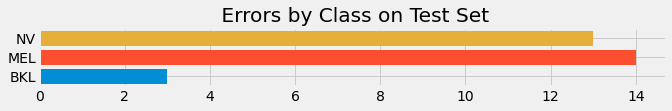

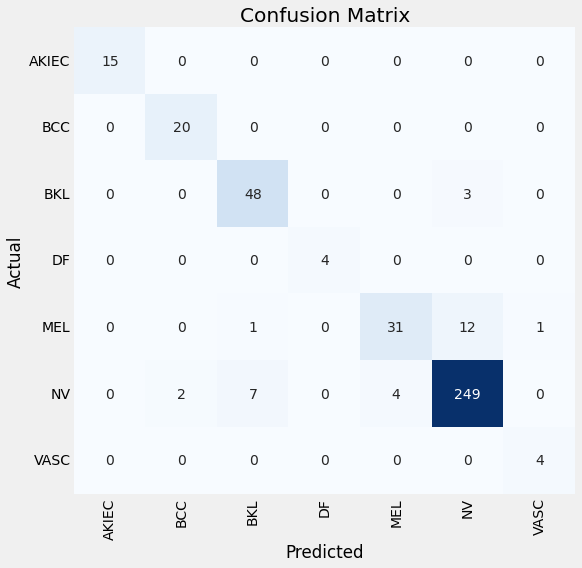

Classification Report:
----------------------
               precision    recall  f1-score   support

       AKIEC       1.00      1.00      1.00        15
         BCC       0.91      1.00      0.95        20
         BKL       0.86      0.94      0.90        51
          DF       1.00      1.00      1.00         4
         MEL       0.89      0.69      0.78        45
          NV       0.94      0.95      0.95       262
        VASC       0.80      1.00      0.89         4

    accuracy                           0.93       401
   macro avg       0.91      0.94      0.92       401
weighted avg       0.93      0.93      0.92       401



In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )


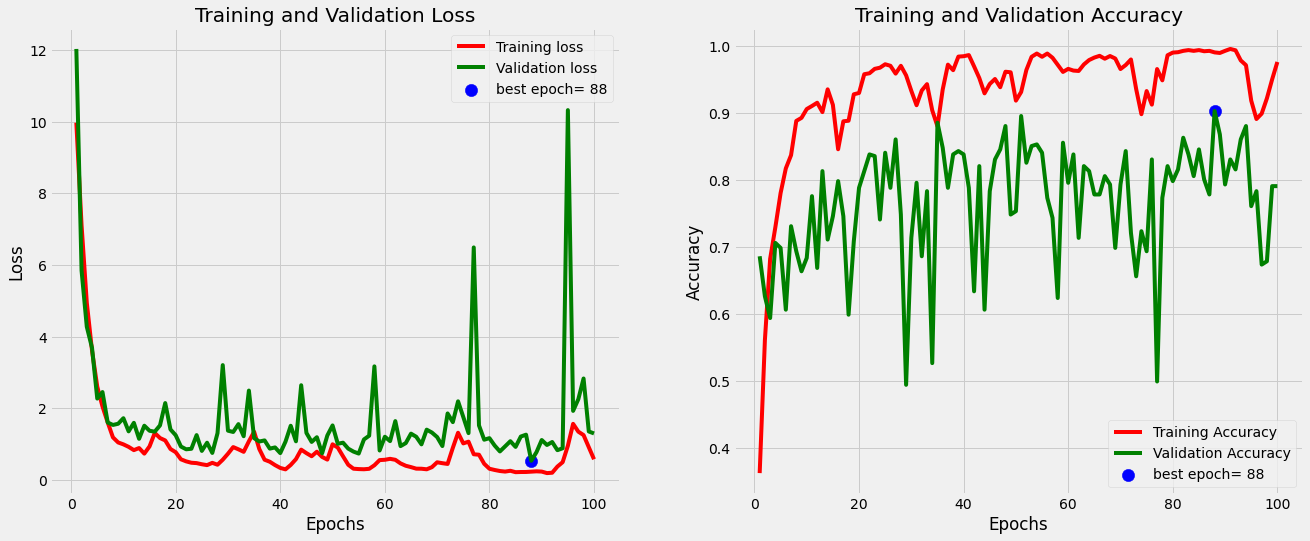

401/401 [==============================] - 8s 19ms/step - loss: 0.4814 - accuracy: 0.9252 - top_2_categorical_accuracy: 0.9825 - top_3_categorical_accuracy: 0.9925
accuracy on the test set is 92.52 %


In [ ]:
tr_plot(history,0)
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [ ]:
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

401/401 [==============================] - 7s 18ms/step - loss: 0.4814 - accuracy: 0.9252 - top_2_categorical_accuracy: 0.9825 - top_3_categorical_accuracy: 0.9925
Restored model, accuracy: 9251.87%
